## Make a static maps

### Download libraries and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from matplotlib.colors import Normalize

#######################################################

filename = '../data/raw/combined_data_from_victor.csv'

shp_name = '../shapefiles/Belgium-4-Digit-Postcodes-2020.shp'

#######################################################

df = pd.read_csv(filename,delimiter=',')

col = 'Url'  # Drop the column Url because it needn't for analysis
if col in df.columns:
    df.drop(columns=[col], inplace=True)

## Create cdata for maps

In [2]:
df_avg = df.groupby('postal_code', as_index=False)['price'].median()
df_avg.rename(columns={'price': 'median_price'}, inplace=True)

df_count = df.groupby('postal_code').size().reset_index(name='count')

df_high = df[df['price'] > 500_000]
df_high_count = df_high.groupby('postal_code').size().reset_index(name='high_price_count')

df_summary = pd.merge(df_avg, df_count, on='postal_code', how='left')
df_summary = df_summary.merge(df_high_count, on='postal_code', how='left')

df_summary['high_price_count'] = df_summary['high_price_count'].fillna(0).astype(int)

###########################################################

df['price_per_m2'] = df['price'] / df['area']

df_price_per_m2 = df.groupby('postal_code', as_index=False)['price_per_m2'].median()
df_price_per_m2.rename(columns={'price_per_m2': 'median_price_per_m2'}, inplace=True)

df_summary = df_summary.merge(df_price_per_m2, on='postal_code', how='left')


## prepare shapefile, join it with data

In [3]:
gdf = gpd.read_file(shp_name)

gdf['nouveau_PO'] = pd.to_numeric(gdf['nouveau_PO'], errors='coerce').astype('Int64')
df_summary['postal_code'] = pd.to_numeric(df_avg['postal_code'], errors='coerce').astype('Int64')

gdf = gdf.merge(df_summary, left_on='nouveau_PO', right_on='postal_code', how='left')

## Create first map

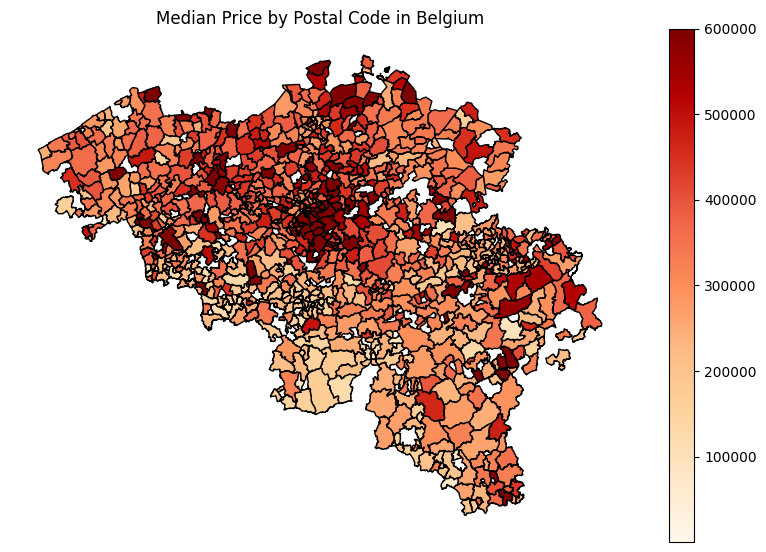

In [4]:
norm = Normalize(vmin=100, vmax=600000)

width_px, height_px = 1500, 1000
dpi = 150
figsize = (width_px / dpi, height_px / dpi)
fig, ax = plt.subplots(figsize=figsize)


gdf.plot(
    cmap='OrRd', 
    column='median_price', 
    legend=True,
    norm=norm,
    ax=ax,
    edgecolor='black')

plt.axis('off')
plt.title('Median Price by Postal Code in Belgium')
plt.show

#######################################################

fig.savefig('belgium_median_price_map_goldfish.png', dpi=dpi, bbox_inches='tight')

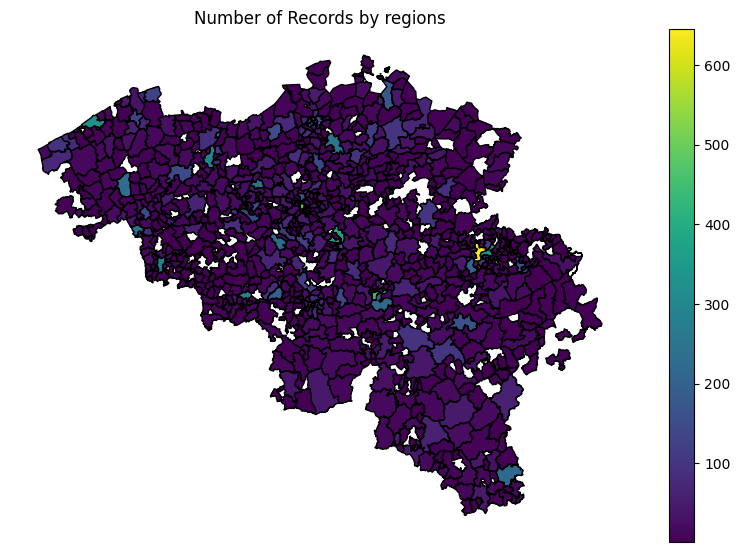

In [5]:
fig, ax = plt.subplots(figsize=figsize)  # figsize тот же, что и для первой карты

gdf.plot(
    column='count', 
    legend=True,
    edgecolor='black',
    ax=ax
)

plt.title('Number of Records by regions')
plt.axis('off')
plt.show()

fig.savefig('map_number_of_records_goldfish.png', dpi=dpi, bbox_inches='tight')

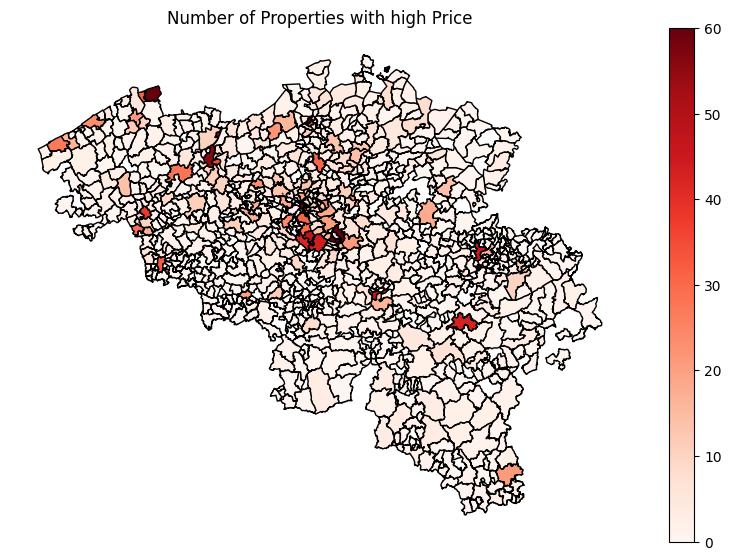

In [6]:
fig, ax = plt.subplots(figsize=figsize)  

norm = Normalize(vmin=0, vmax=60)

gdf.plot(
    column='high_price_count',
    cmap='Reds',
    legend=True,
    ax=ax,
    norm=norm,
    edgecolor='black'
)

plt.axis('off')
plt.title('Number of Properties with high Price')
plt.show()

fig.savefig('map_high_valued_properties_goldfish.png', dpi=dpi, bbox_inches='tight')

## Price by sq.meter

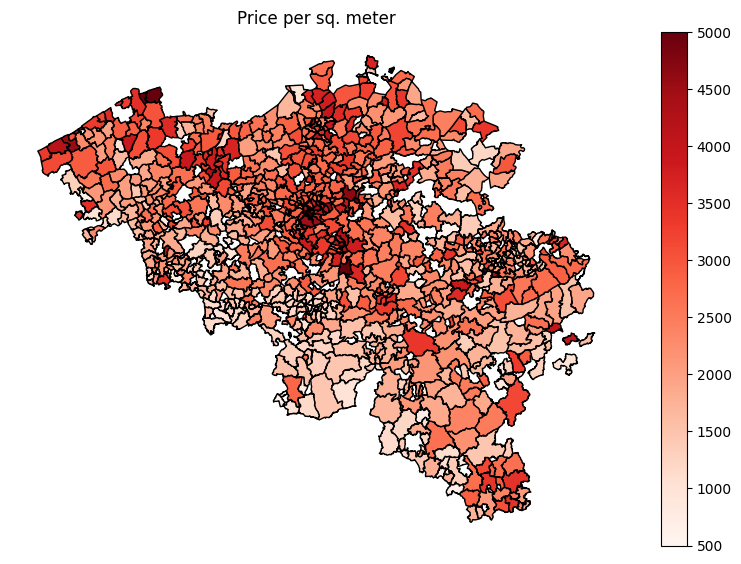

In [7]:

#print(df_summary.head())

#pd.set_option('display.float_format', '{:.0f}'.format)
#print( df_summary['median_price_per_m2'].describe() )
'''
df_summary['median_price_per_m2'].plot(kind='hist', bins=100, range=(500, 5000), edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Prices')
plt.show()

'''
fig, ax = plt.subplots(figsize=figsize)  

norm = Normalize(vmin=500, vmax=5000)

gdf.plot(
    column='median_price_per_m2',
    cmap='Reds',
    legend=True,
    ax=ax,
    norm=norm,
    edgecolor='black'
)

plt.axis('off')
plt.title('Price per sq. meter')
plt.show()

fig.savefig('map_price_by_m2_goldfish.png', dpi=dpi, bbox_inches='tight')
